# Implementation of RAG
It utilize large data (in this case PDF) to add up additional information semantically to make llm answer more specific and hallucinate less.

### Acknowledgement
1. https://www.youtube.com/@mrdbourke \
   Local Retrieval Augmented Generation (RAG) from Scratch tutorial
  
2. Huggingface platform for model and pipeline. https://huggingface.co/

Tools used : pymupdf PDF library, spacy

### Preprocessing Data

In [1]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("File does not exist, downloading file")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2e22/open/download?type=pdf"

    filename = pdf_path
    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"File downloaded and saved as {filename}")
    else:
        print(f"File download failed, please recheck input url : {url}")
else:
    print(f"File already exists as {pdf_path}")

File does not exist, downloading file
File downloaded and saved as human-nutrition-text.pdf


In [2]:
pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 26.5 MB/s eta 0:00:00


In [3]:
import pymupdf #pip install pymupdf
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """ Replace '\n' by ' ' """
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = pymupdf.open(pdf_path)
    pages_texts = []
    for page_number, page in (pbar := tqdm(enumerate(doc))):
        text = page.get_text()
        text = text_formatter(text = text)
        pbar.set_description(f"Processing page = {page_number}")
        d = {
            "page_number" : page_number-33,
            "page_char_count" : len(text),
            "page_word_count" : len(text.split(" ")),
            "page_sentence_count" : len(text.split(". ")),
            "page_token_count" : len(text)/4,
            "text" : text
        }
        pages_texts.append(d)

    return pages_texts

In [4]:
pages_texts = open_and_read_pdf(pdf_path)
pages_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -33,
  'page_char_count': 18,
  'page_word_count': 3,
  'page_sentence_count': 1,
  'page_token_count': 4.5,
  'text': 'Human Nutrition 2e'},
 {'page_number': -32,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
import random
random.sample(pages_texts, k=1)

[{'page_number': 922,
  'page_char_count': 1661,
  'page_word_count': 296,
  'page_sentence_count': 16,
  'page_token_count': 415.25,
  'text': 'activity level. For example, dental problems can lead to difficulties  with chewing and swallowing, which in turn can make it hard to  maintain a healthy diet. The use of dentures or the preparation of  pureed or chopped foods can help solve this problem. There also  is a decreased thirst response in the elderly, and the kidneys have  a decreased ability to concentrate urine, both of which can lead to  dehydration.  Sensory Issues  At about age sixty, taste buds begin to decrease in size and number.  As a result, the taste threshold is higher in older adults, meaning  that more of the same flavor must be present to detect the taste.  Many elderly people lose the ability to distinguish between salty,  sour, sweet, and bitter flavors. This can make food seem less  appealing and decrease the appetite. An intake of foods high in  sugar and sodium 

In [6]:
import pandas as pd
df = pd.DataFrame(pages_texts)
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1198.000000,1198.000000,1198.000000,1198.000000,1198.000000
mean,565.500000,1138.199499,196.978297,10.047579,284.549875
std,345.977119,563.658803,96.425009,6.146518,140.914701
min,-33.000000,0.000000,1.000000,1.000000,0.000000
25%,266.250000,737.250000,130.000000,5.000000,184.312500
50%,565.500000,1222.000000,213.000000,10.000000,305.500000
75%,864.750000,1596.750000,270.000000,15.000000,399.187500
max,1164.000000,2310.000000,431.000000,34.000000,577.500000


In [7]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")
doc = nlp("This is a sentence Another one. No way another one. what have i done?")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence Another one., No way another one., what have i done?]

In [8]:
pages_texts[600]

{'page_number': 567,
 'page_char_count': 1157,
 'page_word_count': 249,
 'page_sentence_count': 19,
 'page_token_count': 289.25,
 'text': 'Table 9.16 Riboflavin Content of Various Foods  Food  Serving Riboflavin  (mg)  Percent Daily  Value  Beef liver  3 oz.  2.9  171  Breakfast cereals,  fortified  1  serving  1.7  100  Instant oats, fortified  1 c.  1.1  65  Plain yogurt, fat free  1 c.  0.6  35  2% milk  8 oz.  0.5  29  Beef, tenderloin steak  3 oz.  0.4  24  Portabella mushrooms,  sliced  ½ c.  0.3  18  Almonds, dry roasted  1 oz.  0.3  18  Egg, scrambled  1 large  0.2  12  Quinoa  1 c.  0.2  12  Salmon, canned  3 oz.  0.2  12  Spinach, raw  1 c.  0.1  6  Brown rice  ½ c.  0  0  Fact Sheet for Health Professionals, Riboflavin. National Institute  of Health, Office of Dietary Supplements. https://ods.od.nih.gov/ factsheets/Riboflavin-HealthProfessional/. Updated February 11,  2016. Accessed October 22, 2017.  Niacin (B3)  Niacin is a component of the coenzymes NADH and NADPH, which 

In [9]:
for item in (pbar := tqdm(pages_texts)):
    item['sentences'] = list(nlp(item["text"]).sents)
    pbar.set_description(f" Page {item['page_number']} :")

    item['sentences'] = [str(sentence) for sentence in  item["sentences"]]
    item['page_sentences_count_spacy'] = len(item["sentences"])


  0%|          | 0/1198 [00:00<?, ?it/s]

In [10]:
random.sample(pages_texts,k=1)

[{'page_number': 135,
  'page_char_count': 734,
  'page_word_count': 139,
  'page_sentence_count': 8,
  'page_token_count': 183.5,
  'text': 'Figure 2.30  BIA Hand  Device  Image by  United  States  Marine  Corps /  Public  Domain  composition. These devices are also sold for home use and  commonly called body composition scales.  \xa0 • Dual-energy X-ray absorptiometry (DEXA). This can be used to  measure bone density. It also can determine fat content via the  same method, which directs two low-dose X-ray beams  through the body and determines the amount of the energy  absorbed from the beams. The amount of energy absorbed is  dependent on the body’s content of bone, lean tissue mass, and  fat mass. Using standard mathematical formulas, fat content  can be accurately estimated.  \xa0 Indicators of Health: Body Mass Index, Body Fat Content, and Fat Distribution  |  135',
  'sentences': ['Figure 2.30  BIA Hand  Device  Image by  United  States  Marine  Corps /  Public  Domain  composit

In [11]:
df = pd.DataFrame(pages_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentences_count_spacy
count,1198.00,1198.00,1198.00,1198.00,1198.00,1198.00
mean,565.50,1138.20,196.98,10.05,284.55,10.38
std,345.98,563.66,96.43,6.15,140.91,6.28
min,-33.00,0.00,1.00,1.00,0.00,0.00
25%,266.25,737.25,130.00,5.00,184.31,5.00
50%,565.50,1222.00,213.00,10.00,305.50,10.00
75%,864.75,1596.75,270.00,15.00,399.19,15.00
max,1164.00,2310.00,431.00,34.00,577.50,27.00


### Chunking sentences together

In [12]:
sentences_chunk_size = 10

def split_list(input_list:list[str], slice_size: int=sentences_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(22))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21]]

In [13]:
for item in tqdm(pages_texts):
    item["sentence_chunks"] = split_list(input_list=item['sentences'], slice_size=sentences_chunk_size)
    item['num_chunks'] = len(item["sentence_chunks"])

  0%|          | 0/1198 [00:00<?, ?it/s]

In [14]:
random.sample(pages_texts, k=1)

[{'page_number': 675,
  'page_char_count': 473,
  'page_word_count': 77,
  'page_sentence_count': 4,
  'page_token_count': 118.25,
  'text': 'downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer.  \xa0 An interactive H5P element has been excluded  from this version of the text. You can view it  online here:  https://pressbooks.oer.hawaii.edu/ humannutrition2e22/?p=370#h5p-111  \xa0 Zinc  |  675',
  'sentences': ['downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).',
   ' Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer.',
   ' \xa0 An interactive H5P element has been excluded  from this version

In [15]:
df = pd.DataFrame(pages_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentences_count_spacy,num_chunks
count,1198.00,1198.00,1198.00,1198.00,1198.00,1198.00,1198.00
mean,565.50,1138.20,196.98,10.05,284.55,10.38,1.52
std,345.98,563.66,96.43,6.15,140.91,6.28,0.64
min,-33.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,266.25,737.25,130.00,5.00,184.31,5.00,1.00
50%,565.50,1222.00,213.00,10.00,305.50,10.00,1.00
75%,864.75,1596.75,270.00,15.00,399.19,15.00,2.00
max,1164.00,2310.00,431.00,34.00,577.50,27.00,3.00


Preprocess sentences to chunks form

In [16]:
import re

pages_chunks = []
for item in tqdm(pages_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        joined_sentence_chunk = "".join(sentence_chunk).replace(" "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        # '.A' => '. A'
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4

        pages_chunks.append(chunk_dict)

  0%|          | 0/1198 [00:00<?, ?it/s]

In [17]:
len(pages_chunks)

1820

In [18]:
df_chunk = pd.DataFrame(pages_chunks)
df_chunk.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1820.00,1820.00,1820.00,1820.00
mean,588.65,746.73,127.56,186.68
std,346.09,454.32,80.23,113.58
min,-33.00,14.00,3.00,3.50
25%,287.75,326.75,51.00,81.69
50%,595.50,749.00,131.00,187.25
75%,893.25,1131.00,194.00,282.75
max,1164.00,1908.00,360.00,477.00


In [19]:
# Filtering chunks below 30 token count
min_token_length = 30
for row in df_chunk[df_chunk["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count : {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count : 19.25 | Text: Published February 6, 2018. Accessed April 15, 2018. Comparing Diets  |  1051
Chunk token count : 21.5 | Text: Centers for Disease Control  and Prevention.http://www.cdc.gov/nutrition/ Iron  |  663
Chunk token count : 11.5 | Text: CHAPTER 6. PROTEIN  Chapter 6. Protein  |  359
Chunk token count : 29.5 | Text: American Journal of Clinical  Dietary, Behavioral, and Physical Activity Recommendations for Weight Management  |  511
Chunk token count : 24.25 | Text: Updated  April 2010. Accessed September 22, 2017. Carbohydrates and Personal Diet Choices  |  289


In [20]:
pages_chunks_filtered = df_chunk[df_chunk["chunk_token_count"] > min_token_length].to_dict(orient="records")
random.sample(pages_chunks_filtered, k=1)

[{'page_number': 481,
  'sentence_chunk': 'characteristics. EER values are different for children, pregnant or  lactating women, and for overweight and obese people. Also,  remember the EER is calculated based on weight maintenance, not  for weight loss or weight gain. The 2015 Dietary Guidelines provides a table (Table 8.3 “Estimated  Daily Calorie Needs”) that gives the estimated daily calorie needs  for different age groups of males and females with various activity  levels. The Dietary Guidelines also states that while knowing the  number of calories you need each day is useful, it is also pertinent  to obtain your calories from nutrient-dense foods and consume  the various macronutrients in their Acceptable Macronutrient  Distribution Ranges (AMDRs) (Table 8.4 “Acceptable Macronutrient  Distribution Ranges”). \xa0 Table 8.3 Estimated Daily Calorie Needs  Sex  Age  (years) Sedentary  Moderately Active  Active  Child  (female and  male)  2–3  1,000  1,000–1,400  (male)1,000-1,200  (

### Creating Embedding from chunks

In [21]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.3 MB/s eta 0:00:00


In [27]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [29]:
sentences = ["I agree to disagree"]

embeddings= embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding[:5]}")
    print(f"Embedding Size: {len(embedding)}")

Sentence: I agree to disagree
Embedding: [ 0.06050643  0.1058007   0.00286424 -0.03094428 -0.02850841]
Embedding Size: 768


In [37]:
# %%time

# embedding_model.to(device)

# for item in tqdm(pages_chunks_filtered):
#     item["embeddings"] = embedding_model.encode(item["sentence_chunk"])

In [34]:
# Creating list to be send in batches of sentence_chunk
text_chunks = [item["sentence_chunk"] for item in pages_chunks_filtered]
type(text_chunks), len(text_chunks)

(list, 1652)

In [39]:
# %%time
embedding_model.to(device)

# Embed all texts in batches
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=16, show_progress_bar=True, convert_to_tensor=True)


Batches:   0%|          | 0/104 [00:00<?, ?it/s]

In [40]:
# Save embeddings to file
df_embeddings_text_chunks = pd.DataFrame(pages_chunks_filtered)
embeddings_df_save_path = "df_embeddings_text_chunks.csv"
df_embeddings_text_chunks.to_csv(embeddings_df_save_path, index=False)

In [41]:
# Importing embeddings from saved file
df_embeddings_text_chunks_load = pd.read_csv(embeddings_df_save_path)
df_embeddings_text_chunks_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-31,Human Nutrition 2e UNIVERSITY OF HAWAI‘I AT M...,336,57,84.00,[ 5.27490638e-02 3.91995050e-02 -2.14749249e-...
1,-30,Human Nutrition 2e by University of Hawai‘i at...,227,32,56.75,[ 4.71064746e-02 2.49445513e-02 -1.79160926e-...
2,-29,Contents Preface xiii About the Contributor...,593,123,148.25,[ 4.23231423e-02 4.20776159e-02 1.22843101e-...
3,-28,The Urinary System 109 The Muscular System ...,798,156,199.50,[ 3.76119837e-02 4.30524573e-02 2.29083351e-...
4,-27,Chapter 5. Lipids Introduction 293 The Func...,813,169,203.25,[ 4.96902876e-02 1.81940384e-02 -3.99908237e-...


### Semantic Search

In [42]:
# As our embedding database is less than 100k-1M samples, vector database is not neccessary
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
# Import dataframe
df_embeddings_text_chunks = pd.read_csv("df_embeddings_text_chunks.csv")

# Convert embedding to np.array
df_embeddings_text_chunks["embeddings"] = df_embeddings_text_chunks["embeddings"].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

# Convert text and embeddings to a list of dicts
pages_chunks = df_embeddings_text_chunks.to_dict(orient="records")

df_embeddings_text_chunks[:1]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-31,Human Nutrition 2e UNIVERSITY OF HAWAI‘I AT M...,336,57,84.0,"[0.0527490638, 0.039199505, -0.00214749249, -0..."


In [43]:
embeddings = np.stack(df_embeddings_text_chunks["embeddings"].tolist(), axis=0)
print(embeddings[:1][0][:5])

[ 0.05274906  0.03919951 -0.00214749 -0.01363679  0.06057926]


In [44]:
embeddings = torch.tensor(np.stack(df_embeddings_text_chunks['embeddings'].tolist(), axis=0), dtype=torch.float32).to(device)
pages_chunks = df_embeddings_text_chunks.to_dict(orient="records")
embeddings.shape

torch.Size([1652, 768])

In [45]:
query = "what are the type of fats"
query_embeddings = embedding_model.encode(query, convert_to_tensor=True).to(device)

In [46]:
query_embeddings.dtype, query_embeddings.shape, embeddings.dtype, embeddings.shape

(torch.float32, torch.Size([768]), torch.float32, torch.Size([1652, 768]))

In [47]:
from sentence_transformers import util
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings:{end_time-start_time:.5f} seconds")

[INFO] Time taken to get scores on 1652 embeddings:0.02433 seconds


In [48]:
dot_scores

tensor([0.3053, 0.2656, 0.2926,  ..., 0.2271, 0.2839, 0.2267], device='cuda:0')

In [49]:
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

torch.return_types.topk(
values=tensor([0.7119, 0.6714, 0.6668, 0.6653, 0.6520], device='cuda:0'),
indices=tensor([442, 484, 446, 421, 445], device='cuda:0'))

In [50]:
pages_chunks_filtered[41]["sentence_chunk"]

'are only required in a few milligrams or less. Macrominerals, such  as calcium, magnesium, potassium, sodium, and phosphorus, are  required in hundreds of milligrams. Many minerals are critical for  enzyme function, others are used to maintain fluid balance, build  bone tissue, synthesize hormones, transmit nerve impulses,  contract and relax muscles, and protect against harmful free  radicals in the body that can cause health problems such as cancer. Vitamins  The thirteen vitamins are categorized as either water-soluble or  fat-soluble. The water-soluble vitamins are vitamin C and all the  B vitamins, which include thiamine, riboflavin, niacin, pantothenic  acid, pyridoxine, biotin, folate and cobalamin. The fat-soluble  vitamins are A, D, E, and K. Vitamins are required to perform many  functions in the body such as making red blood cells, synthesizing  bone tissue, and playing a role in normal vision, nervous system  function, and immune system function. Table 1.3 Water-soluble Vi

Can use Indexing library for vector search : Faiss<br>

One technique that library provides is Approximate Nearest Neighbour search (ANN)

In [51]:
import textwrap
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [52]:
top_index=-1
for value, index in zip(top_results_dot_product[0], top_results_dot_product[1]):
    if top_index==-1:
        top_index = index
    print(f"Value: {value:.4f}")
    print("Text:")
    print_wrapped(pages_chunks[index]["sentence_chunk"])
    print(f"Page number:{pages_chunks[index]['page_number']}")

Value: 0.7119
Text:
Figure 5.4  Structures of  a Saturated,  Monounsatu rated, and  Polyunsatura ted
Fat  Image by  Allison  Calabrese /  CC BY 4.0    Fatty Acid Types in the Body
The fatty-acid profile of the diet directly correlates to the  tissue lipid
profile of the body. It may not solely be the  quantity of dietary fat that
matters. More directly, the type  of dietary fat ingested has been shown to
affect body  weight, composition, and metabolism. The fatty acids  consumed are
often incorporated into the triglycerides  within the body. Evidence confirms
that saturated fatty  acids are linked to higher rates of weight retention when
compared to other types of fatty acids. Alternatively, the  How Lipids Work  |
309
Page number:309
Value: 0.6714
Text:
fats. The AHA guidelines also recommend consuming fish, especially  oily fish,
at least twice per week.3  These more appropriate dietary choices will allow for
enjoyment  of a wide variety of foods while providing the body with the
rec

In [53]:
# Orders of the result can be potentially improved by using Reranking model to reranking smaller order like top 25
# Example mixedbread reranking model

### [Extra] obtaining page image

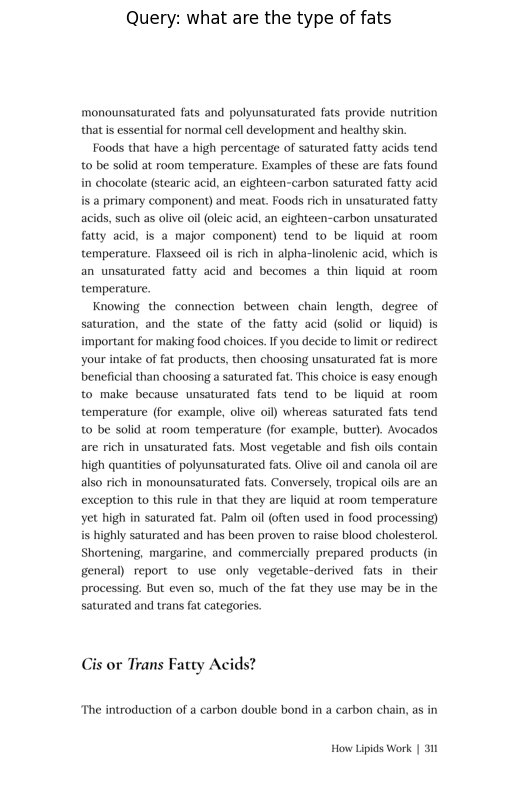

In [54]:
import pymupdf #pip install pymupdf

pdf_path = "human-nutrition-text.pdf"
doc = pymupdf.open(pdf_path)
page = doc.load_page(pages_chunks[index]['page_number']+33)

img = page.get_pixmap(dpi = 300)
doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query}")
plt.axis("off")
plt.show()

In [55]:
def cosine_similarity(vector1, vector2):
    dot_vector = torch.dot(vector1, vector2)
    vec1_norm = torch.sqrt(torch.sum(vector1**2))
    vec2_norm = torch.sqrt(torch.sum(vector2**2))
    return dot_vector/ (vec1_norm*vec2_norm)

In [56]:
vec1 = torch.tensor([1,2,3])
vec2 = torch.tensor([1,2,3])
vec3 = torch.tensor([4,5,6])
vec4 = torch.tensor([-1,-31,-27])

print(f"Dot product {vec1} and {vec2} is {torch.dot(vec1, vec2)}") # Same high value
print(f"Dot product {vec1} and {vec3} is {torch.dot(vec1, vec3)}") # Same higher value because of high magnitude.
print(f"Dot product {vec1} and {vec4} is {torch.dot(vec1, vec4)}")
print(f"Dot product {vec3} and {vec4} is {torch.dot(vec3, vec4)}")

#  ! Same vectors should have highest value

Dot product tensor([1, 2, 3]) and tensor([1, 2, 3]) is 14
Dot product tensor([1, 2, 3]) and tensor([4, 5, 6]) is 32
Dot product tensor([1, 2, 3]) and tensor([ -1, -31, -27]) is -144
Dot product tensor([4, 5, 6]) and tensor([ -1, -31, -27]) is -321


In [57]:
print(f"Cosine similarity {vec1} and {vec2} is {cosine_similarity(vec1, vec2)}") # Same high value
print(f"Cosine similarity {vec1} and {vec3} is {cosine_similarity(vec1, vec3)}") # Same higher value because of high magnitude.
print(f"Cosine similarity {vec1} and {vec4} is {cosine_similarity(vec1, vec4)}")
print(f"Cosine similarity {vec3} and {vec4} is {cosine_similarity(vec3, vec4)}")

Cosine similarity tensor([1, 2, 3]) and tensor([1, 2, 3]) is 0.9999999403953552
Cosine similarity tensor([1, 2, 3]) and tensor([4, 5, 6]) is 0.9746317863464355
Cosine similarity tensor([1, 2, 3]) and tensor([ -1, -31, -27]) is -0.9358940720558167
Cosine similarity tensor([4, 5, 6]) and tensor([ -1, -31, -27]) is -0.8895859122276306


### Retreival semantic search function

In [58]:
def retrieve_semantic_result(
        query:str,
        embeddings:torch.tensor,
        model: SentenceTransformer=embedding_model,
        num_passages: int=5,
        print_time:bool=True):

    query_embeddings = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embeddings, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

    scores, indices = torch.topk(input=dot_scores, k=num_passages)

    return scores, indices

In [59]:
def print_top_results_and_scores(
        query:str,
        embeddings:torch.tensor,
        pages_chunks:list[dict]=pages_chunks,

        num_passages:int=5):
    scores, indices = retrieve_semantic_result(query=query, embeddings=embeddings)

    for value, index in zip(scores, indices):
        print(f"Value: {value:.4f}")
        print("Text:")
        print_wrapped(pages_chunks[index]["sentence_chunk"])
        print(f"Page number:{pages_chunks[index]['page_number']}\n")

In [60]:
query="hungry feeling"
print_top_results_and_scores(query=query, embeddings=embeddings)

Time taken to get scores on 1652 embeddings: 0.00008 seconds
Value: 0.6102
Text:
Figure 8.7  Sagittal View  of the Brain  Hypothalam us by  Methoxyroxy
~commonswi ki / Public  Domain  This is a scan of a brain. The hypothalamus
contains distinct centers  of neural circuits that regulate hunger and satiety.
Hunger pangs are real and so is a “growling” stomach. When the  stomach is empty
it contracts, producing the characteristic pang  and “growl.”The stomach’s
mechanical movements relay neural  signals to the hypothalamus, which relays
other neural signals to  parts of the brain. This results in the conscious
feeling of the need  to eat. Alternatively, after you eat a meal the stomach
stretches and  sends a neural signal to the brain stimulating the sensation of
satiety  and relaying the message to stop eating. The stomach also sends out
certain hormones when it is full and others when it is empty. These  hormones
communicate to the hypothalamus and other areas of the  brain either to s

### Importing LLM model

In [61]:
if(torch.cuda.is_available()):
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [67]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [68]:
!pip install bitsandbytes

In [79]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
# Quantization configuration
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

if(is_flash_attn_2_available() and torch.cuda.get_device_capability(0)[0] >= 0):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product implementation

In [76]:
model_id = "google/gemma-2b-it"
use_quantization_config = False

In [77]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_id, device=device)
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path = model_id,
    torch_dtype = torch.float16,
    quantization_config = quantization_config if use_quantization_config else None,
    low_cpu_mem_usage = False,
    attn_implementation = attn_implementation
)
if not use_quantization_config and torch.cuda.is_available():
    llm_model.to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [80]:
print(f"Using implementation {attn_implementation}")
print(f"Parameters count : {sum([param.numel() for param in llm_model.parameters()])/2**30:.3f} billions")
print(f"Memory size used : {round(sum([param.nelement()*param.element_size() for param in llm_model.parameters()])/2**30,2)} GB")
print(f"Buffer size used : {round(sum([param.nelement()*param.element_size() for param in llm_model.buffers()])/2**30,3)} GB")

Using implementation sdpa
Parameters count : 2.334 billions
Memory size used : 4.67 GB
Buffer size used : 0.0 GB


### Inferencing query

In [83]:
input_text = "What are micronutrients"
prompt_base_template = [{"role":"user","content":input_text}]

prompt_formatted = tokenizer.apply_chat_template(
    conversation=prompt_base_template,
    tokenize=False,
    add_generation_prompt=True
)
prompt_tokenized = tokenizer.apply_chat_template(
    conversation=prompt_base_template,
    tokenize=True,
    add_generation_prompt=True
)
print(f"Prompt formatted : \n{prompt_formatted}")
print(f"Prompt tokenized : \n{prompt_tokenized}")

Prompt formatted : 
<bos><start_of_turn>user
What are micronutrients<end_of_turn>
<start_of_turn>model

Prompt tokenized : 
[2, 106, 1645, 108, 1841, 708, 92800, 184592, 107, 108, 106, 2516, 108]


In [84]:
input_ids = tokenizer(prompt_formatted, return_tensors="pt").to(device)

outputs = llm_model.generate(**input_ids, max_new_tokens=256)
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Decoded Output : {outputs_decoded}")

Decoded Output : <bos><bos><start_of_turn>user
What are micronutrients<end_of_turn>
<start_of_turn>model
Sure, here's a summary of micronutrients:

**Micronutrients** are nutrients that the body needs in small amounts to maintain good health. They are essential for various bodily functions, including:

* **Energy production:** They provide the building blocks for energy-producing molecules like ATP (adenosine triphosphate).
* **Cell function:** They regulate various cellular processes, including metabolism, reproduction, and growth.
* **Immune function:** They help the body fight infections and disease.
* **Bone health:** They contribute to the development and maintenance of strong bones and teeth.
* **Blood formation:** They help produce red blood cells and platelets.
* **Brain function:** They are involved in memory, learning, and other cognitive processes.
* **Metabolism:** They help the body break down food and use it for energy.
* **Water balance:** They help regulate fluid levels

In [86]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How we experience pain?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]
query_list = gpt4_questions + manual_questions

In [96]:
sample_prompt = """Based on the following context items, please answer the query.
Use the context items as additional data in constructing your answer
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}"""

In [101]:
# Format prompt
def prompt_formatter(query: str, context_items: list[dict]) -> str:
  context = "- "+ "\n - ".join([item["sentence_chunk"] for item in context_items])
  base_prompt = sample_prompt
  base_prompt = base_prompt.format(context=context, query=query)
  # Create prompt
  prompt_template = [{"role":"user","content":base_prompt}]
  prompt = tokenizer.apply_chat_template(conversation=prompt_template, tokenize=False, add_generation_prompt=True)
  return prompt

query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_semantic_result(query = query, embeddings = embeddings)
context_items = [pages_chunks[index] for index in indices]
prompt = prompt_formatter(query = query, context_items = context_items)
# print(f"Prompt: {prompt}")

Query: Explain the concept of energy balance and its importance in weight management.
Time taken to get scores on 1652 embeddings: 0.00009 seconds


In [102]:
%%time
input_ids = tokenizer(prompt, return_tensors="pt").to(device)
outputs = llm_model.generate(**input_ids, temperature=0.7, max_new_tokens=256, do_sample=True)
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Decoded Output : {outputs_decoded}")

Decoded Output : <bos><bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 d

In [110]:
 # Creating a function to ask query to llm

def ask(query:str, temperature:float=0.7, max_new_token:int=256, format_answer_text=True, return_answer_only=True):
  # get passages(score, index)
  scores, indices = retrieve_semantic_result(query = query, embeddings = embeddings)

  # get passage for each index
  context_items = [pages_chunks[index] for index in indices]

  for i, item in enumerate(context_items):
    item["score"] = scores[i]

  # format prompt
  prompt = prompt_formatter(query = query, context_items = context_items)
  input_ids = tokenizer(prompt, return_tensors="pt").to(device)

  outputs = llm_model.generate(**input_ids, temperature=temperature, max_new_tokens=max_new_token, do_sample=True)
  output_text = tokenizer.decode(outputs[0])

  if format_answer_text:
    output_text = output_text.replace(prompt, "").replace("<bos>","").replace("<eos>","")

  if return_answer_only:
    return output_text

  return output_text, context_items

In [116]:
query = random.choice(query_list)
print(f"Query: {query}")
print(ask(query=query))

Query: What are the macronutrients, and what roles do they play in the human body?
Time taken to get scores on 1652 embeddings: 0.00010 seconds
Sure, here are the relevant passages from the context about the macronutrients, and what roles they play in the human body:

**Carbohydrates** provide a ready source of energy for the body and provide structural constituents for the formation of cells. They also function as a source of energy for muscle and nerve cells.

**Lipids** provide stored energy for the body, functions as structural components of cells and also as signaling molecules for proper cellular communication. They also play a role in the absorption of certain nutrients, such as cholesterol.

**Proteins** provide structure to bones, muscles, and skin, and play a role in conducting most of the chemical reactions that take place in the body. They also assist in the production of enzymes, which are proteins that catalyze chemical reactions.
